# Report for Transaction-Receipt Matcher Task

In [85]:
import cupy as cp # linear algebra
import cudf # data processing, CSV file I/O (e.g. cudf.read_csv)
from cuml.preprocessing.model_selection import train_test_split
from cuml.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from cuml.preprocessing.LabelEncoder import LabelEncoder

from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split as sktrain_test_split
import sklearn
from random import shuffle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost
from cupy import asnumpy

from ray.tune.schedulers import ASHAScheduler
from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback


import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pprint

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)

### **Preview dataset** <a class="anchor" id="4.3.2"></a> 

In [98]:
data = cudf.read_csv('/kaggle/input/tide-data/data_interview_test (1).csv',sep=":")

pdf = pd.read_csv('/kaggle/input/tide-data/data_interview_test (1).csv',sep=":")
data.head()

receipt_id  company_id matched_transaction_id feature_transaction_id  \
0     10,000       10000                 10,468                 10,000   
1     10,000       10000                 10,468                 10,001   
2     10,000       10000                 10,468                 10,003   
3     10,000       10000                 10,468                 10,004   
4     10,000       10000                 10,468                 10,005   

   DateMappingMatch  AmountMappingMatch  DescriptionMatch  \
0               0.0                 0.0               0.0   
1               0.0                 0.0               0.0   
2               0.0                 0.0               0.0   
3               0.0                 0.0               0.0   
4               0.0                 0.0               0.0   

   DifferentPredictedTime  TimeMappingMatch  PredictedNameMatch  \
0                     1.0               0.0                 0.0   
1                     1.0               0.0                 0.0   
2                     1.0               0.0                 0.0   
3                     1.0               0.0                 0.0   
4                     1.0               0.0                 0.0   

   ShortNameMatch  DifferentPredictedDate  PredictedAmountMatch  \
0             0.0                     1.0                   0.0   
1             0.0                     1.0                   0.0   
2             0.0                     1.0                   0.0   
3             0.0                     1.0                   0.0   
4             0.0                     1.0                   0.0   

   PredictedTimeCloseMatch  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0

### Shape of dataset

In [6]:
data.shape

(12034, 14)

We have total 12034 samples and each have mathcing feature vector of size of 10

### Create labels 
- Transaction and Receipt are correct matches where matched_transaction_id = feature_transaction_id
- We create a column for the labels using above condition

In [63]:
data['label']= (data.matched_transaction_id == data.feature_transaction_id).astype(int)
pdf['label'] = (pdf.matched_transaction_id == pdf.feature_transaction_id).astype(int)

### Let's check the distribution of label ( or correct vs wrong matches)

0    11177
1      857
Name: label, dtype: int64


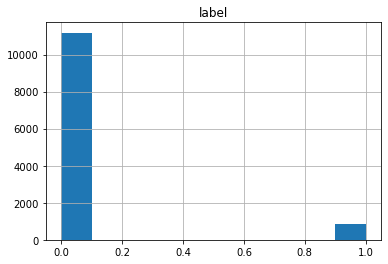

In [22]:
pdf.hist('label')
print(pdf.label.value_counts())

- The total samples in data are 12304 out of which 11177 are wrong matchings and only 857 correct match
- Highly unbalanced data

## Evaluation Metric
- Befor creating the models, we need to decide a evaluation metric.
- Simple accuracy is bad metric here due to higly imbalanced data as randomly labeling as all incorrect matching the accuracy will be very high.
- Recall = true positives/(true positives + false negatives) 
- Precison = true positives/(true positives + false positives)
- recall is could be looked as ability of model to correctly label all true positives. and precison is ability to not label negative sample as positive.
- Both of these are important but the major priority we will consider as to get a high Recall, so that correct matching could be found.

## Baseline
- Create a baseline model using matching vector as feature.
- Starting with simple linear regression and random forest, and xgboost model.
- Xgboost model produces better result for baseline, so moving forward we will be optimizing the xgboost model only.


In [28]:


data['label']= (data.matched_transaction_id == data.feature_transaction_id).astype(int)
x,y = data[list(data.columns[4:])], data.label
x=x.drop(['label'], axis=1)  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,shuffle=True)
    
train = xgboost.DMatrix(X_train, label=y_train)
test = xgboost.DMatrix(X_test, label=y_test)
watchlist = [(test, 'eval'), (train, 'train')]

xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'gpu_hist',
            'max_depth': 2, 
            'eta':0.1,
            'silent':1,
            'subsample':0.5,
            'colsample_bytree': 0.05,
            
}

clf = xgboost.train( xgb_params,train, num_boost_round=10000,                 )

preds = clf.predict(test)



[13:04:03] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3363
           1       0.84      0.60      0.70       247

    accuracy                           0.96      3610
   macro avg       0.91      0.79      0.84      3610
weighted avg       0.96      0.96      0.96      3610

 In the Confusion Matrix below, the digonal values represent correct classification for each class : 


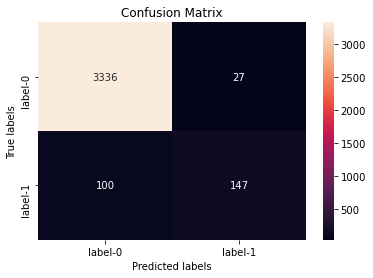

In [42]:
print(classification_report(asnumpy(y_test),preds.round(0)))
print( " In the Confusion Matrix below, the digonal values represent correct classification for each class : ")
labels = ['label-0', 'label-1']
#print(confusion_matrix((y_test),(preds.round(0).astype(int))))  


cm = sklearn.metrics.confusion_matrix(asnumpy(y_test),asnumpy(preds.round(0).astype(int)))
 

ax= plt.subplot()
sns.heatmap(cm.astype(int), annot=True,fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        

- The baseline XGB produces decent results the precesion is high, but recall is low, meaning the model is missing lot of correct matches, which is not good.


### Feature Engineering
- Now we dont have much inforamtion about how the features were created so it's hard to engineer any more features out of these, but looking at some of the features it could be seen all are values between 0-1 and some the value are related to the final label.
- Lets see the how distrubution of each feature value.



 Distribuition of DateMappingMatch feature values


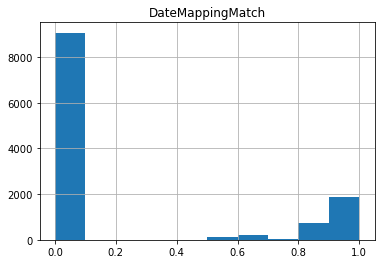

In [45]:
pdf.hist("DateMappingMatch")
print(" Distribuition of DateMappingMatch feature values")

- It could be seen  DateMappingMatch is 0 for more than 8k samples.
- If we check if this distribution is related to the label:

DateMappingMatch related to average label value 


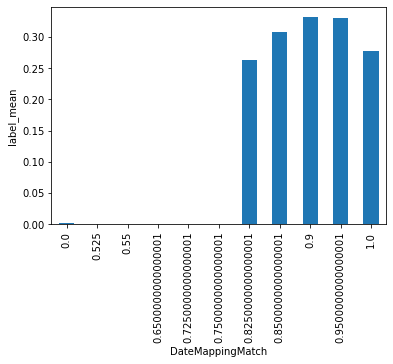

In [50]:
dg = data.groupby('DateMappingMatch').agg({'label':['mean']})
dg.columns = ['label_mean']
ax = dg.label_mean.to_pandas().plot.bar()
ax.set_ylabel('label_mean')

print ("DateMappingMatch related to average label value ")

- Now it could be seen here that for DateMappingMatch values > 0.8 the corresponds to higher label mean, or larger DateMappingMatch value is realted to postive label.
-  We can group these value in bins and count the size of each bin to create a new feature.
- Using these new feature 

[14:23:03] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3361
           1       0.80      0.61      0.69       249

    accuracy                           0.96      3610
   macro avg       0.89      0.80      0.84      3610
weighted avg       0.96      0.96      0.96      3610

 In the Confusion Matrix below, the digonal values represent correct classification for each class : 


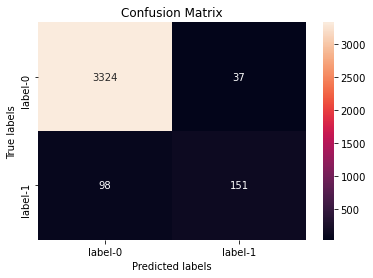

In [64]:

org_data = data.copy()
feat_col=data.columns[4:-1]
le = LabelEncoder()
for col in feat_col:
    var_count = data.groupby(col).agg({col:'count'})
    var_count.columns = ['%s_count'%col]
    var_count = var_count.reset_index()
    data = data.merge(var_count,on=col,how='left')
    le.fit(data['%s_count'%col])  
    encoded = le.transform(data['%s_count'%col])
    data['%s_count'%col] = encoded/encoded.max()
    


x,y = data[list(data.columns[4:])], data.label
x=x.drop(['label'], axis=1)  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,shuffle=True)
    
train = xgboost.DMatrix(X_train, label=y_train)
test = xgboost.DMatrix(X_test, label=y_test)
watchlist = [(test, 'eval'), (train, 'train')]

xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'gpu_hist',
            'max_depth': 2, 
            'eta':0.1,
            'silent':1,
            'subsample':0.5,
            'colsample_bytree': 0.05,
            
}

clf = xgboost.train( xgb_params,train, num_boost_round=10000,                 )

preds = clf.predict(test)
print(classification_report(asnumpy(y_test),preds.round(0)))
print( " In the Confusion Matrix below, the digonal values represent correct classification for each class : ")
labels = ['label-0', 'label-1']
#print(confusion_matrix((y_test),(preds.round(0).astype(int))))  


cm = sklearn.metrics.confusion_matrix(asnumpy(y_test),asnumpy(preds.round(0).astype(int)))
 

ax= plt.subplot()
sns.heatmap(cm.astype(int), annot=True,fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        


- As seen from above results the new features doesn't make much diffrence
- For now we won't use them as they don't provide any significant improvenment but will cause problems as creating these features during testing on new data will not be straight forward

### We need to handle the class imbalance to improve the results.
-  The best method would to have weighted loss, meaning if rare class is missclassifed the model would penalised more.
- Now the weight by which we should be mupltiplying the loss could be taken as the imbalance proportion or any other value also might work, for now we could use 13 (which is class imbalance ratio)

[14:31:24] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3352
           1       0.32      0.98      0.49       258

    accuracy                           0.85      3610
   macro avg       0.66      0.91      0.70      3610
weighted avg       0.95      0.85      0.88      3610

 In the Confusion Matrix below, the digonal values represent correct classification for each class : 


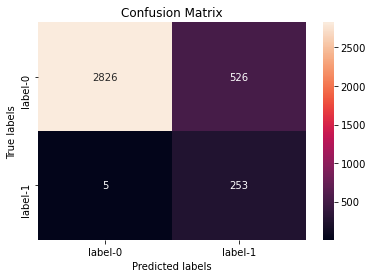

In [71]:

data = org_data
data['label']= (data.matched_transaction_id == data.feature_transaction_id).astype(int)
x,y = data[list(data.columns[4:])], data.label
x=x.drop(['label'], axis=1)  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,shuffle=True)
    
train = xgboost.DMatrix(X_train, label=y_train)
test = xgboost.DMatrix(X_test, label=y_test)
watchlist = [(test, 'eval'), (train, 'train')]

xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'gpu_hist',
            'max_depth': 2, 
            'eta':0.1,
            'silent':1,
            'subsample':0.5,
            'colsample_bytree': 0.05,
            'scale_pos_weight':13,
}

clf = xgboost.train( xgb_params,train, num_boost_round=20000,                 )

preds = clf.predict(test)

print(classification_report(asnumpy(y_test),preds.round(0)))
print( " In the Confusion Matrix below, the digonal values represent correct classification for each class : ")
labels = ['label-0', 'label-1']
#print(confusion_matrix((y_test),(preds.round(0).astype(int))))  


cm = sklearn.metrics.confusion_matrix(asnumpy(y_test),asnumpy(preds.round(0).astype(int)))
 

ax= plt.subplot()
sns.heatmap(cm.astype(int), annot=True,fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        

- So this weighted loss trick improved the recall value significantly, although precesion for is not that high, but better recall value is more preferable.
- Now as seen from Confusion Matrix, we can see we have more false postives (527) now although this is bad we shoudld check the confidence of model for these false postives.

In [72]:
tp = np.logical_and(preds.round(0)==1,asnumpy(y_test)==1)
fp = np.logical_and(preds.round(0)==1,asnumpy(y_test)==0)
xtest = X_test.copy()
xtest['scores']=preds
xtest.scores[fp].describe()

count    526.000000
mean       0.725985
std        0.087234
min        0.500826
25%        0.701039
50%        0.710187
75%        0.710187
max        0.999817
Name: scores, dtype: float64

- The above stats signify that mean confidance of model classifying false postives is 0.72 also majority of false positivea have around 0.71 confidence, which is not good as model showing dignigicant confidance in wrong predection
- We can check the model confidence for true postives (meaning correctly classifying the postive class) :

In [74]:
xtest.scores[tp].describe()

count    253.000000
mean       0.880693
std        0.134692
min        0.500826
25%        0.710187
50%        0.968476
75%        0.993914
max        0.999996
Name: scores, dtype: float64

 - mean confidence for true postive is 0.88 which is good and higher than mean confidance in false postives, but it is still a problem, we somehow need to increase this diffrence without affecting recall value much.
 - Now the reason for this might be the we maybe using high weight(13) in the weighted loss, we can try to bring it down.

[14:41:00] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3336
           1       0.34      0.96      0.50       274

    accuracy                           0.86      3610
   macro avg       0.67      0.91      0.71      3610
weighted avg       0.95      0.86      0.88      3610

 In the Confusion Matrix below, the digonal values represent correct classification for each class : 


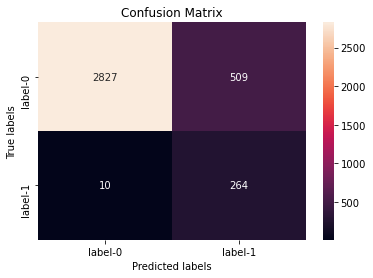

In [75]:

data = org_data
data['label']= (data.matched_transaction_id == data.feature_transaction_id).astype(int)
x,y = data[list(data.columns[4:])], data.label
x=x.drop(['label'], axis=1)  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,shuffle=True)
    
train = xgboost.DMatrix(X_train, label=y_train)
test = xgboost.DMatrix(X_test, label=y_test)
watchlist = [(test, 'eval'), (train, 'train')]

xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'gpu_hist',
            'max_depth': 2, 
            'eta':0.1,
            'silent':1,
            'subsample':0.5,
            'colsample_bytree': 0.05,
            'scale_pos_weight':8,
}

clf = xgboost.train( xgb_params,train, num_boost_round=20000,                 )

preds = clf.predict(test)

print(classification_report(asnumpy(y_test),preds.round(0)))
print( " In the Confusion Matrix below, the digonal values represent correct classification for each class : ")
labels = ['label-0', 'label-1']
#print(confusion_matrix((y_test),(preds.round(0).astype(int))))  


cm = sklearn.metrics.confusion_matrix(asnumpy(y_test),asnumpy(preds.round(0).astype(int)))
 

ax= plt.subplot()
sns.heatmap(cm.astype(int), annot=True,fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        

In [77]:
tp = np.logical_and(preds.round(0)==1,asnumpy(y_test)==1)
fp = np.logical_and(preds.round(0)==1,asnumpy(y_test)==0)
xtest = X_test.copy()
xtest['scores']=preds
print ( "false postive stats")
print(xtest.scores[fp].describe())
print()
print ( "True postive stats")
print(xtest.scores[tp].describe())

false postive stats
count    509.000000
mean       0.632003
std        0.093489
min        0.518502
25%        0.604750
50%        0.604750
75%        0.609394
max        0.998062
Name: scores, dtype: float64

True postive stats
count    264.000000
mean       0.854777
std        0.164180
min        0.537738
25%        0.609394
50%        0.945672
75%        0.989480
max        0.999992
Name: scores, dtype: float64


 - Okay so we have brought the model confidence  in false postives lower and also diffrence of confidence between the 2 cases increased which is good, and overall model is still not affected that much.
 - We are going in right direction.

### HyperParameter optimization 
- now that we have very good model already, we can try to select best hyperparmeters for the xgb model we are using to further improve the performance.
- We will be suing Ray Tune library for this purpose as it integrated nicely with the Cuml and Xgboost library we are using for faster trainging on GPU (compared to normal Scikit-Learn models on CPU).
- Now after lot of trials setting diffrenet parameter search space, the resulting model is a huge improvenment over our previous best, also when the recall value is comaprable on cheking it is found that the model confidence is very low for both true psotives almsot same as for false positives which is not correct. 
- We can try different Hyperparameter search algorithms but the major problem comes in setting right metric for the search as simple accuracy or loss or AUC doesn't produce good result for our aim for matching right recipt with good confidence, also it's very time consuming and it very often produce overfitted model due to amount of data.
- So we will won't use the model from the hyperparameter search results and go with out intial choosen model.

In [80]:
!pip uninstall -y dataclasses

Found existing installation: dataclasses 0.6
Uninstalling dataclasses-0.6:
  Successfully uninstalled dataclasses-0.6


In [93]:

def prep_data(path):
    data = cudf.read_csv(path,sep=":")
    data['label']= (data.matched_transaction_id == data.feature_transaction_id).astype(int)
    feat_col=data.columns[4:-1]
    le = LabelEncoder()
    for col in feat_col:
        var_count = data.groupby(col).agg({col:'count'})
        var_count.columns = ['%s_count'%col]
        var_count = var_count.reset_index()
        data = data.merge(var_count,on=col,how='left')
        le.fit(data['%s_count'%col])  
        encoded = le.transform(data['%s_count'%col])
        data['%s_count'%col] = encoded/encoded.max()
    x,y = data[list(data.columns[4:])], data.label
    x=x.drop(['label'], axis=1)  
    return x,y
path = "/kaggle/input/tide-data/data_interview_test (1).csv"
x,y = prep_data(path)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,shuffle=True)

def train_receipt_match(config):
       
    train = xgboost.DMatrix(X_train, label=y_train)
    test = xgboost.DMatrix(X_test, label=y_test)
    watchlist = [(test, 'eval'), (train, 'train')]
    clf = xgboost.train(config, train, num_boost_round=10000,
                        evals=watchlist,
                        maximize=True,
                        verbose_eval=1000,
                        callbacks=[TuneReportCheckpointCallback(filename="model.xgb")]
                       )
    

search_space = {
    # You can mix constants with search space objects.
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error", "aucpr"],
    "max_depth": tune.randint(1, 9),
    "min_child_weight": tune.choice([1, 2, 3]),
    "subsample": tune.uniform(0.4, 1.0),
    "eta": tune.loguniform(1e-4, 1e-1),
    "scale_pos_weight":tune.randint(3, 13),
}

# This will enable aggressive early stopping of bad trials.
scheduler = ASHAScheduler(
    max_t=10,  # 10 training iterations
    grace_period=1,
    reduction_factor=2)

analysis = tune.run(
    train_receipt_match,
    metric="eval-aucpr",
    mode="max",
    # You can add "gpu": 0.1 to allocate GPUs
    resources_per_trial={"gpu": 1},
    config=search_space,
    num_samples=10,
    scheduler=scheduler)

        

Result for train_receipt_match_f992b_00000:
  date: 2021-01-25_15-07-05
  done: false
  eval-aucpr: 0.72666
  eval-error: 0.046814
  eval-logloss: 0.692783
  experiment_id: 76f7dc1cd4e04a6fa24f0361faac3d99
  experiment_tag: 0_eta=0.00044393,max_depth=7,min_child_weight=3,scale_pos_weight=5,subsample=0.70897
  hostname: f1a12c4e1819
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 7750
  should_checkpoint: true
  time_since_restore: 0.1828763484954834
  time_this_iter_s: 0.1828763484954834
  time_total_s: 0.1828763484954834
  timestamp: 1611587225
  timesteps_since_restore: 0
  train-aucpr: 0.73618
  train-error: 0.04594
  train-logloss: 0.692816
  training_iteration: 1
  trial_id: f992b_00000
  
(pid=7750) [0]	eval-logloss:0.69278	eval-error:0.04681	eval-aucpr:0.72666	train-logloss:0.69282	train-error:0.04594	train-aucpr:0.73618
Result for train_receipt_match_f992b_00000:
  date: 2021-01-25_15-07-05
  done: true
  eval-aucpr: 0.721994
  eval-error: 0.046814
  eval-logloss: 0.

Result for train_receipt_match_f992b_00002:
  date: 2021-01-25_15-07-15
  done: true
  eval-aucpr: 0.328842
  eval-error: 0.144321
  eval-logloss: 0.686411
  experiment_id: e43d2df8634a4d0f9045578a8639ac67
  experiment_tag: 2_eta=0.0092726,max_depth=1,min_child_weight=1,scale_pos_weight=7,subsample=0.84922
  hostname: f1a12c4e1819
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 7804
  should_checkpoint: true
  time_since_restore: 0.17534327507019043
  time_this_iter_s: 0.17534327507019043
  time_total_s: 0.17534327507019043
  timestamp: 1611587235
  timesteps_since_restore: 0
  train-aucpr: 0.312987
  train-error: 0.15254
  train-logloss: 0.686527
  training_iteration: 1
  trial_id: f992b_00002
  
Result for train_receipt_match_f992b_00003:
  date: 2021-01-25_15-07-20
  done: true
  eval-aucpr: 0.512174
  eval-error: 0.144321
  eval-logloss: 0.692109
  experiment_id: 8c3d179f10ca4f159d0ed784f614fba7
  experiment_tag: 3_eta=0.0013786,max_depth=2,min_child_weight=3,scale_pos_w

Result for train_receipt_match_f992b_00004:
  date: 2021-01-25_15-07-25
  done: false
  eval-aucpr: 0.69076
  eval-error: 0.144321
  eval-logloss: 0.668687
  experiment_id: 896e87c31a20476d9a6983059383a431
  experiment_tag: 4_eta=0.031367,max_depth=4,min_child_weight=2,scale_pos_weight=6,subsample=0.70668
  hostname: f1a12c4e1819
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 7859
  should_checkpoint: true
  time_since_restore: 0.1788349151611328
  time_this_iter_s: 0.1788349151611328
  time_total_s: 0.1788349151611328
  timestamp: 1611587245
  timesteps_since_restore: 0
  train-aucpr: 0.692353
  train-error: 0.152184
  train-logloss: 0.668983
  training_iteration: 1
  trial_id: f992b_00004
  
Result for train_receipt_match_f992b_00004:
  date: 2021-01-25_15-07-25
  done: true
  eval-aucpr: 0.676641
  eval-error: 0.145429
  eval-logloss: 0.645803
  experiment_id: 896e87c31a20476d9a6983059383a431
  experiment_tag: 4_eta=0.031367,max_depth=4,min_child_weight=2,scale_pos_weigh

(pid=7884) [0]	eval-logloss:0.69280	eval-error:0.14432	eval-aucpr:0.70933	train-logloss:0.69282	train-error:0.15218	train-aucpr:0.72974
Result for train_receipt_match_f992b_00005:
  date: 2021-01-25_15-07-30
  done: true
  eval-aucpr: 0.719673
  eval-error: 0.144321
  eval-logloss: 0.691767
  experiment_id: da172e9a704347f2b3e2d720a2969244
  experiment_tag: 5_eta=0.0004369,max_depth=6,min_child_weight=2,scale_pos_weight=7,subsample=0.95511
  hostname: f1a12c4e1819
  iterations_since_restore: 4
  node_ip: 172.19.2.2
  pid: 7884
  should_checkpoint: true
  time_since_restore: 0.29499077796936035
  time_this_iter_s: 0.029791831970214844
  time_total_s: 0.29499077796936035
  timestamp: 1611587250
  timesteps_since_restore: 0
  train-aucpr: 0.736076
  train-error: 0.152184
  train-logloss: 0.691777
  training_iteration: 4
  trial_id: f992b_00005
  
Result for train_receipt_match_f992b_00006:
  date: 2021-01-25_15-07-35
  done: true
  eval-aucpr: 0.604372
  eval-error: 0.144321
  eval-loglos

Result for train_receipt_match_f992b_00007:
  date: 2021-01-25_15-07-40
  done: false
  eval-aucpr: 0.709861
  eval-error: 0.144321
  eval-logloss: 0.659001
  experiment_id: 12a454e2f92e4bbbba6bf1ce41b7b9ae
  experiment_tag: 7_eta=0.044111,max_depth=6,min_child_weight=2,scale_pos_weight=7,subsample=0.81343
  hostname: f1a12c4e1819
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 7939
  should_checkpoint: true
  time_since_restore: 0.18074345588684082
  time_this_iter_s: 0.18074345588684082
  time_total_s: 0.18074345588684082
  timestamp: 1611587260
  timesteps_since_restore: 0
  train-aucpr: 0.730665
  train-error: 0.152184
  train-logloss: 0.659259
  training_iteration: 1
  trial_id: f992b_00007
  
(pid=7939) [0]	eval-logloss:0.65900	eval-error:0.14432	eval-aucpr:0.70986	train-logloss:0.65926	train-error:0.15218	train-aucpr:0.73067


Result for train_receipt_match_f992b_00007:
  date: 2021-01-25_15-07-41
  done: true
  eval-aucpr: 0.72349
  eval-error: 0.144321
  eval-logloss: 0.450133
  experiment_id: 12a454e2f92e4bbbba6bf1ce41b7b9ae
  experiment_tag: 7_eta=0.044111,max_depth=6,min_child_weight=2,scale_pos_weight=7,subsample=0.81343
  hostname: f1a12c4e1819
  iterations_since_restore: 10
  node_ip: 172.19.2.2
  pid: 7939
  should_checkpoint: true
  time_since_restore: 0.6663346290588379
  time_this_iter_s: 0.04856371879577637
  time_total_s: 0.6663346290588379
  timestamp: 1611587261
  timesteps_since_restore: 0
  train-aucpr: 0.748466
  train-error: 0.152184
  train-logloss: 0.451963
  training_iteration: 10
  trial_id: f992b_00007
  
Result for train_receipt_match_f992b_00008:
  date: 2021-01-25_15-07-45
  done: false
  eval-aucpr: 0.71
  eval-error: 0.128532
  eval-logloss: 0.6893
  experiment_id: 1b0506032776425e8abc2b722e46bac9
  experiment_tag: 8_eta=0.0047856,max_depth=8,min_child_weight=2,scale_pos_weight=

Result for train_receipt_match_f992b_00008:
  date: 2021-01-25_15-07-46
  done: true
  eval-aucpr: 0.708323
  eval-error: 0.127147
  eval-logloss: 0.68548
  experiment_id: 1b0506032776425e8abc2b722e46bac9
  experiment_tag: 8_eta=0.0047856,max_depth=8,min_child_weight=2,scale_pos_weight=6,subsample=0.60178
  hostname: f1a12c4e1819
  iterations_since_restore: 2
  node_ip: 172.19.2.2
  pid: 7970
  should_checkpoint: true
  time_since_restore: 0.26717257499694824
  time_this_iter_s: 0.08506107330322266
  time_total_s: 0.26717257499694824
  timestamp: 1611587266
  timesteps_since_restore: 0
  train-aucpr: 0.737473
  train-error: 0.13331
  train-logloss: 0.685486
  training_iteration: 2
  trial_id: f992b_00008
  
(pid=7970) [0]	eval-logloss:0.68930	eval-error:0.12853	eval-aucpr:0.71000	train-logloss:0.68935	train-error:0.13390	train-aucpr:0.73323
Result for train_receipt_match_f992b_00009:
  date: 2021-01-25_15-07-50
  done: true
  eval-aucpr: 0.603654
  eval-error: 0.145429
  eval-logloss: 

2021-01-25 15:07:50,906	INFO tune.py:439 -- Total run time: 50.36 seconds (50.26 seconds for the tuning loop).


- As seen below sometime the resulting model performs lesser than our previous best.

("Best model parameters: {'objective': 'binary:logistic', 'eval_metric': "
 "['logloss', 'error', 'aucpr'], 'max_depth': 6, 'min_child_weight': 2, "
 "'subsample': 0.8134274124592183, 'eta': 0.04411116108730761, "
 "'scale_pos_weight': 7}")
Best model total eval-aucpr: 0.72349
              precision    recall  f1-score   support

           0       0.93      0.77      0.85      3352
           1       0.08      0.27      0.13       258

    accuracy                           0.74      3610
   macro avg       0.51      0.52      0.49      3610
weighted avg       0.87      0.74      0.79      3610

 In the Confusion Matrix below, the digonal values represent correct classification for each class : 


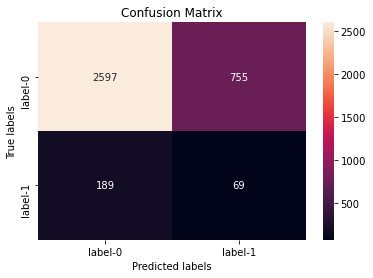

In [94]:
best_bst = xgboost.Booster()
best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
aucpr = analysis.best_result["eval-aucpr"]
pprint.pprint(f"Best model parameters: {analysis.best_config}")
print(f"Best model total eval-aucpr: {aucpr}")

preds = best_bst.predict(test)

print(classification_report(asnumpy(y_test),preds.round(0)))
print( " In the Confusion Matrix below, the digonal values represent correct classification for each class : ")
labels = ['label-0', 'label-1']
#print(confusion_matrix((y_test),(preds.round(0).astype(int))))  


cm = sklearn.metrics.confusion_matrix(asnumpy(y_test),asnumpy(preds.round(0).astype(int)))
 

ax= plt.subplot()
sns.heatmap(cm.astype(int), annot=True,fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        

### Conclusion

- We were able to make good classifier which is able to match the correct ‘transaction-receipt’ with high confidence.
- Selecting the right metric was the hard as all the usual metrics comes with some issues, and we need to further analyse the model to check how confident the model is in making right or wrong decision even it produce results on choosen metrics.
- Hyper-Paramet search is hard for such kind of imbalnced data and low number of samples.
- Due to limited information on current feature vector new feature engineering is difficult.

- Creating an ensemble of models would have resulted in little better performance but it's hard to deploy, so did't created any ensemble of multiple models